# Problem Statement

An MNC financial organisation operates in multiple geographies in various product segments (liabilities as well as credit). In the past few years, the bank has been on an expansion spree. As part of this expansion drive, it is looking to grow its customer base who purchase credit products. So, the bank is looking to push credit cards to new customers in one of the markets in which it is operating. Now, since this market is not mature in terms of data governance and reporting, the credit bureau (such as CIBIL and Experian) does not have data on all the existing card customers.

In order to expand its credit card portfolio, the bank is looking to build a credit card application approval model. Normally, banks process credit card applications based on credit bureau scores. Since this market does not have a credit bureau score for the majority of the customers, building such an application approval model becomes tricky. As the bank has some presence in the credit card space in the region, the data available to build the model contains the application data and performance of these customers. For a good understanding of the data set, you can go through the data description given below.

## Setup system properties and import required libraries

In [1]:
# Defining the environment variables 
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Needed only in windows laptop
#import findspark

#findspark.init()

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count

In [5]:
spark = SparkSession.builder.getOrCreate()
spark

21/07/13 13:25:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

## Load csv data into sprak dataframe

In [7]:
credit_record = sqlContext.read.csv("credit_record.csv", header=True, inferSchema=True)

#drop duplicates
credit_record = credit_record.dropDuplicates()

In [8]:
application_record = sqlContext.read.csv('application_record.csv', header=True, inferSchema=True)

#drop duplicates
application_record = application_record.dropDuplicates()

### Analyze the schema for application record and credit records

In [9]:
application_record.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



Based on data dictionay we are assuming the below columns are all categorical
Categorical Columns : CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, 
NAME_HOUSING_TYPE, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, OCCUPATION_TYPE

In [10]:
credit_record.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



In [11]:
application_record_cols = application_record.columns

In [12]:
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', \
                      'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', \
                      'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL', 'OCCUPATION_TYPE']
binary_categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL']

### Before analysing other columns, let's add the target value[delinquent]

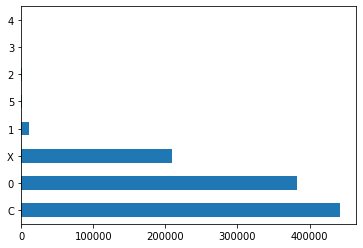

In [13]:
credit_record.toPandas().STATUS.value_counts().plot.barh()
plt.show()

In [14]:
#0 means good customers who are not deliquent and 1 means bad customers who are delinquent.
credit_record = credit_record.withColumn('delinquent', when((col('STATUS') == '0') | (col('STATUS') == '1') | (col('STATUS') == 'C') | (col('STATUS') == 'X'),0).otherwise(1))

In [15]:
p_credit_record = credit_record.toPandas()

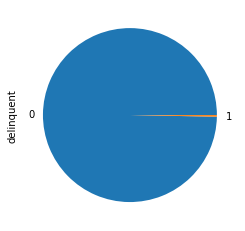

In [16]:
p_credit_record.delinquent.value_counts().plot.pie()
plt.show()

In [17]:
p_credit_record.delinquent.value_counts(normalize=True)

0    0.99704
1    0.00296
Name: delinquent, dtype: float64

In [18]:
delinquent_by_id = credit_record.groupBy('ID').sum('delinquent')

In [19]:
delinquent_by_id = delinquent_by_id.withColumnRenamed('sum(delinquent)','delinquent')

In [20]:
delinquent_by_id = delinquent_by_id.withColumn('delinquent', when(col('delinquent') == 0,0).otherwise(1))

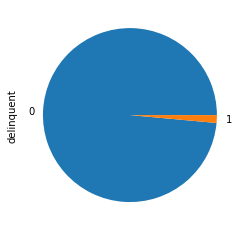

In [21]:
delinquent_by_id.toPandas().delinquent.value_counts(normalize=True).plot.pie()
plt.show()

In [22]:
delinquent_by_id.toPandas().delinquent.value_counts(normalize=True)

0    0.985495
1    0.014505
Name: delinquent, dtype: float64

*We have 1.5% of users whose credit cards are delinquent and 98.5 users who are not deliquent.*
*But, this is based on credit records we got, So, let's join this data with application recoreds to form the target value and see how many applications are deliquent and how many are not.*

#### Lets do a left join on application_record with delinquent_by_id.

In [23]:
application_record = application_record.join(delinquent_by_id, on='ID', how='left')

In [24]:
p_application_record = application_record.toPandas()

In [25]:
p_application_record.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,delinquent
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000,36457.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465,0.016897
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207,0.128886
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


*Based on the description, we can see that there are a huge amount of missing values in delinquent. Lets see how many rows are missing.*

In [26]:
#No of rows missing the target column [delinquent]
print("No of rows missing the target column: ",application_record.filter(col('delinquent').isNull()).count())
print("% of rows missing the target column: ",(application_record.filter(col('delinquent').isNull()).count()/application_record.count())*100)

No of rows missing the target column:  402100


[Stage 34:==============>                                           (1 + 3) / 4]

% of rows missing the target column:  91.68705550247745


In [27]:
application_record.filter(col('delinquent').isNull()).toPandas().head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,delinquent
0,6423752,M,Y,N,1,405000.0,State servant,Secondary / secondary special,Married,House / apartment,-14166,-2404,1,0,0,0,Medicine staff,3.0,None
1,5552083,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15191,-1748,1,1,1,0,Core staff,2.0,None
2,6318202,F,Y,Y,0,247500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20415,365243,1,0,1,0,None,2.0,None
3,6318409,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12953,-1737,1,1,1,0,Laborers,2.0,None
4,6389176,M,N,N,0,81000.0,Working,Secondary / secondary special,Married,With parents,-11352,-671,1,1,0,0,Laborers,2.0,None


*The rows with missing target values is of no use for training and testing the model. So, we will drop the rows.*

In [28]:
application_record_complete = application_record
application_record_to_predict = application_record.filter(col('delinquent').isNull())
application_record = application_record.filter(col('delinquent').isNotNull())

In [29]:
print("% of delinquent customers: ",(application_record.filter(col('delinquent') == 1).count()/application_record.count())*100)
print("% of non-delinquent customers: ",(application_record.filter(col('delinquent') == 0).count()/application_record.count())*100)

% of delinquent customers:  1.6896617933455853


[Stage 64:=========================================>            (153 + 4) / 200]

% of non-delinquent customers:  98.31033820665441


In [30]:
application_record_cols += ['delinquent']
p_application_record = application_record.toPandas()

### EDA on application records

In [31]:
# Find Count of Null, None, NaN of All DataFrame Columns
application_record.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in application_record_cols]).toPandas()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,delinquent
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11323,0,0


*Based on the above results we can see that OCCUPATION_TYPE has 11323 missing values. Which is ~31% of data.*
*Note: We need to correct this. We need to add/update the missing values.*

In [32]:
# Find Count of Null, None, NaN of All DataFrame Columns
credit_record.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in credit_record.columns]).toPandas()

,ID,MONTHS_BALANCE,STATUS,delinquent
0,0,0,0,0


In [33]:
application_record.select(*binary_categorical_columns).show()

[Stage 83:==============>                                           (1 + 3) / 4]

+-----------+------------+---------------+----------+---------------+----------+----------+
|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|
+-----------+------------+---------------+----------+---------------+----------+----------+
|          F|           N|              Y|         1|              0|         0|         0|
|          F|           N|              N|         1|              0|         0|         0|
|          F|           N|              Y|         1|              0|         0|         0|
|          M|           N|              Y|         1|              0|         1|         1|
|          F|           N|              Y|         1|              0|         0|         0|
|          F|           N|              N|         1|              0|         0|         0|
|          F|           N|              Y|         1|              0|         0|         0|
|          M|           N|              N|         1|              0|         0|

*We can see that few binary categorical columns are in string format and few are in integer format. So, we will convert all to integer format while analyzing each column.*

#### Univariant analysis on binary categorical columns

##### CODE_GENDER

In [34]:
#Is there any null values in CODE_GENDER 
application_record.filter(col("CODE_GENDER").isNull()).count()

0

In [35]:
#What are the unique values in CODE_GENDER
code_gender = application_record.select(col("CODE_GENDER")).distinct()
code_gender.show()

+-----------+
|CODE_GENDER|
+-----------+
|          F|
|          M|
+-----------+



We can see that there are only two distict columns.

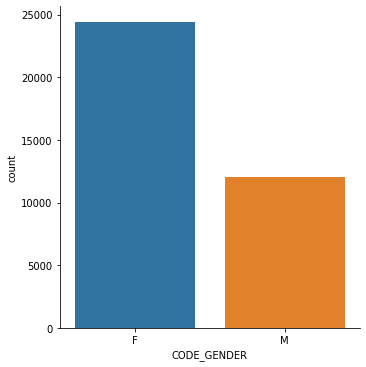

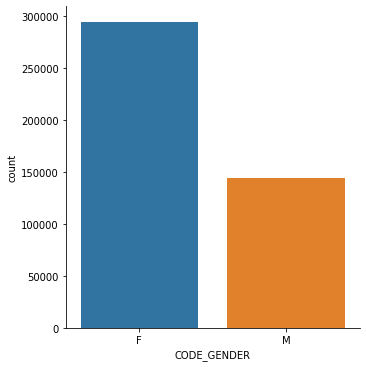

In [36]:
#Let us see the count of values CODE_GENDER
p_code_gender = application_record.select(col('CODE_GENDER')).toPandas()
sns.catplot(x='CODE_GENDER',kind="count", data = p_code_gender,legend=True)
sns.catplot(x='CODE_GENDER',kind="count", data = application_record_complete.select(col('CODE_GENDER')).toPandas(),legend=True)
plt.show()

In [37]:
#we can see that the number of females is almost double to the number of males
#What is the proportion of females in the applicant customer base?
print("Customers with cradit cards in applicant base: ",p_code_gender.value_counts(normalize=True))
print("All customers applicant base: ",application_record_complete.select(col('CODE_GENDER')).toPandas().value_counts(normalize=True))

Customers with cradit cards in applicant base:  CODE_GENDER
F              0.670105
M              0.329895
dtype: float64


All customers applicant base:  CODE_GENDER
F              0.671384
M              0.328616
dtype: float64


*We can see that the ration of Male and female is preety much same.*

In [38]:
#Let us conver the CODE_GENDER to integer values {M: 1, F: 0}
application_record = application_record.withColumn("CODE_GENDER", when(application_record.CODE_GENDER == "M",1).otherwise(0))

#### Let us do analysis for FLAG_OWN_CAR, FLAG_OWN_REALTY, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL

##### FLAG_OWN_CAR

In [39]:
#What are the unique values in FLAG_OWN_CAR
flag_own_car = application_record.select(col("FLAG_OWN_CAR")).distinct()
flag_own_car.show()

+------------+
|FLAG_OWN_CAR|
+------------+
|           Y|
|           N|
+------------+



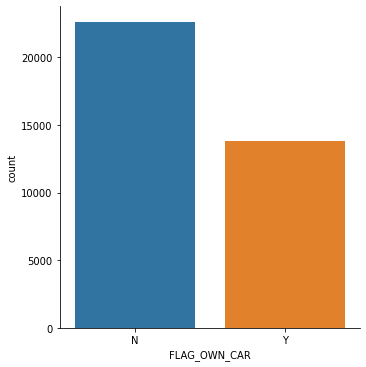

In [40]:
#Let us see the count of values FLAG_OWN_CAR
p_flag_own_car = application_record.select(col('FLAG_OWN_CAR')).toPandas()
sns.catplot(x='FLAG_OWN_CAR',kind="count", data = p_flag_own_car,legend=True)
plt.show()

In [41]:
#we can see that the number of people who own cars are less
p_flag_own_car.value_counts(normalize=True)

FLAG_OWN_CAR
N               0.620292
Y               0.379708
dtype: float64

In [42]:
#Let us conver the FLAG_OWN_CAR to integer values {Y: 1, N: 0}
application_record = application_record.withColumn("FLAG_OWN_CAR", when(application_record.FLAG_OWN_CAR == "Y",1).otherwise(0))

##### FLAG_OWN_REALTY

In [43]:
#What are the unique values in FLAG_OWN_REALTY
flag_own_reality = application_record.select(col("FLAG_OWN_REALTY")).distinct()
flag_own_reality.show()

+---------------+
|FLAG_OWN_REALTY|
+---------------+
|              Y|
|              N|
+---------------+



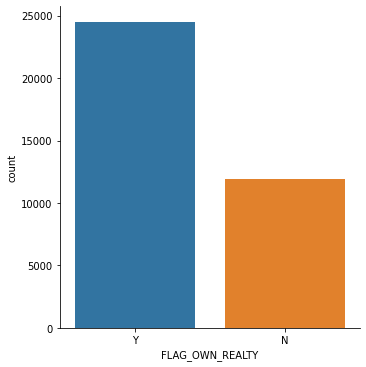

In [44]:
#Let us see the count of values FLAG_OWN_REALTY
p_flag_own_reality = application_record.select(col('FLAG_OWN_REALTY')).toPandas()
sns.catplot(x='FLAG_OWN_REALTY',kind="count", data = p_flag_own_reality,legend=True)
plt.show()

In [45]:
#we can see that the number of people who own propert are more
p_flag_own_reality.value_counts(normalize=True)

FLAG_OWN_REALTY
Y                  0.672189
N                  0.327811
dtype: float64

In [46]:
#Let us conver the FLAG_OWN_REALITY to integer values {Y: 1, N: 0}
application_record = application_record.withColumn("FLAG_OWN_REALTY", when(application_record.FLAG_OWN_REALTY == "Y",1).otherwise(0))

###### Bi-variate Analysis on CODE_GENDER and FLAG_OWN_REALTY

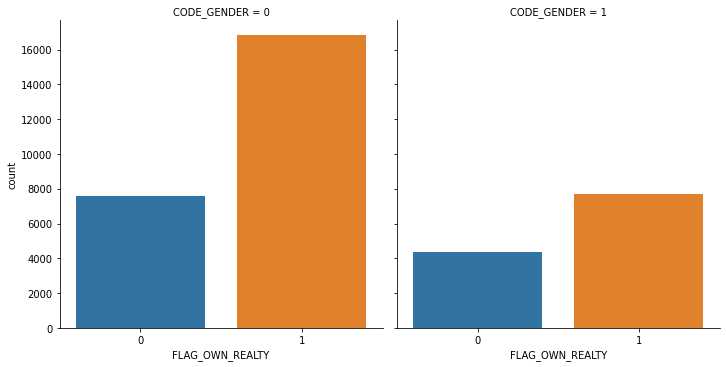

In [47]:
#Is property higher among male applicants or female applicants?
p_who_own_propety = application_record.select(col('CODE_GENDER'),col('FLAG_OWN_REALTY')).toPandas()
sns.catplot(x='FLAG_OWN_REALTY',kind="count",col='CODE_GENDER', data = p_who_own_propety,legend=True)
plt.show()

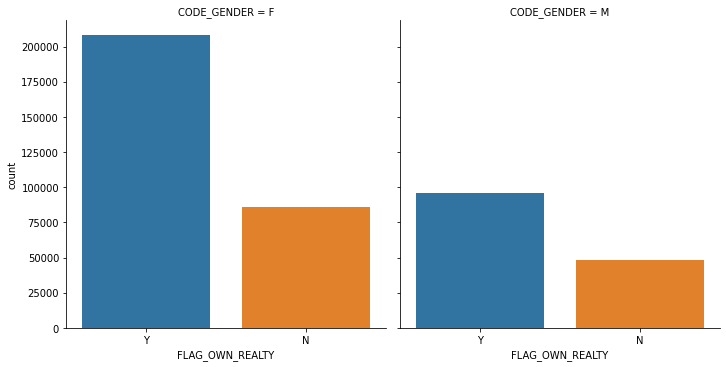

In [48]:
p_who_own_propety = application_record_complete.select(col('CODE_GENDER'),col('FLAG_OWN_REALTY')).toPandas()
sns.catplot(x='FLAG_OWN_REALTY',kind="count",col='CODE_GENDER', data = p_who_own_propety,legend=True)
plt.show()

*The home ownership is more among female applicants than male applicants in complete data as well as data who already hold customers.*

*Note: Do not get confused with colors. Data reprasent as pointed out.*

##### FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL

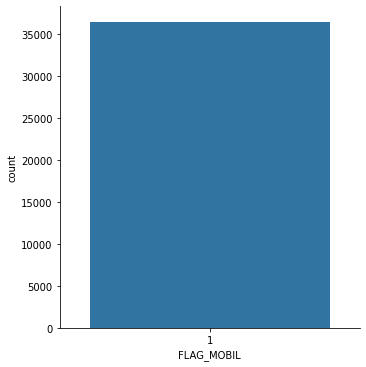

In [49]:
p_flag_mobile = application_record.select(col('FLAG_MOBIL')).toPandas()
sns.catplot(x='FLAG_MOBIL',kind="count", data = p_flag_mobile,legend=True)
plt.show()

We can see that there is only one values, that is everyone in the dataset having a phone. But, does it mean that everyone have work phone and normal phone?
Let us see the count of work phone and normal phone?

Eitherway, this coulmn can be dropped as it does not help in our model.

In [50]:
#Drop column FLAG_MOBILE
application_record = application_record.drop('FLAG_MOBIL')
application_record_cols = application_record.columns
application_record_cols

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'delinquent']

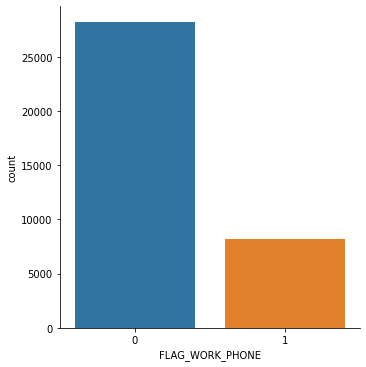

In [51]:
sns.catplot(x='FLAG_WORK_PHONE',kind="count", data = application_record.select(col('FLAG_WORK_PHONE')).toPandas(),legend=True)
plt.show()

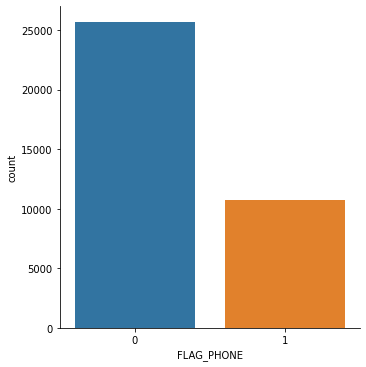

In [52]:
sns.catplot(x='FLAG_PHONE',kind="count", data = application_record.select(col('FLAG_PHONE')).toPandas(),legend=True)
plt.show()

We are seeing that as an individual column majority of people don't have work phone or personel phone.

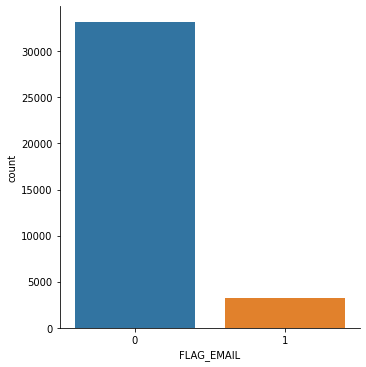

In [53]:
sns.catplot(x='FLAG_EMAIL',kind="count", data = application_record.select(col('FLAG_EMAIL')).toPandas(),legend=True)
plt.show()

### Analyze the columsn which are not binary

In [54]:
non_binary_categorical_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', \
                      'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

In [55]:
p_non_binary_categorical_columns_df = application_record.select(*non_binary_categorical_columns).toPandas()

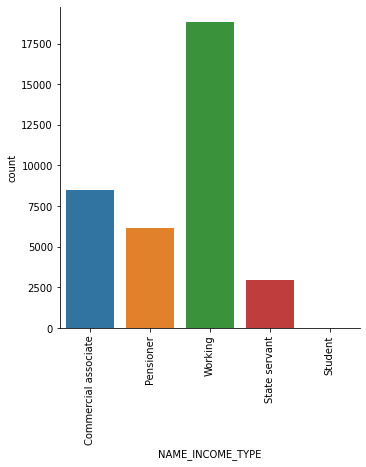

In [56]:
sns.catplot(x='NAME_INCOME_TYPE', kind="count", data = p_non_binary_categorical_columns_df,legend=True)
plt.xticks(rotation=90)
plt.show()

*Our applicant base is more of working class and lest is the student class.*

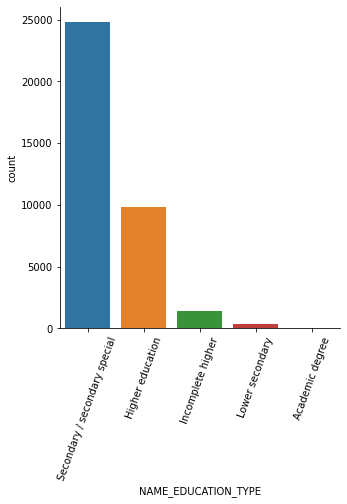

In [57]:
sns.catplot(x='NAME_EDUCATION_TYPE', kind="count", data = p_non_binary_categorical_columns_df,legend=True)
degrees = 70  
plt.xticks(rotation=degrees)
plt.show()

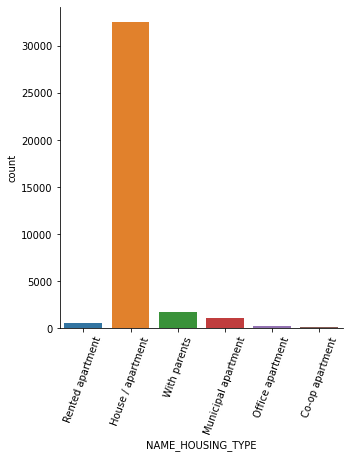

In [58]:
sns.catplot(x='NAME_HOUSING_TYPE', kind="count", data = p_non_binary_categorical_columns_df,legend=True)
degrees = 70  
plt.xticks(rotation=degrees)
plt.show()

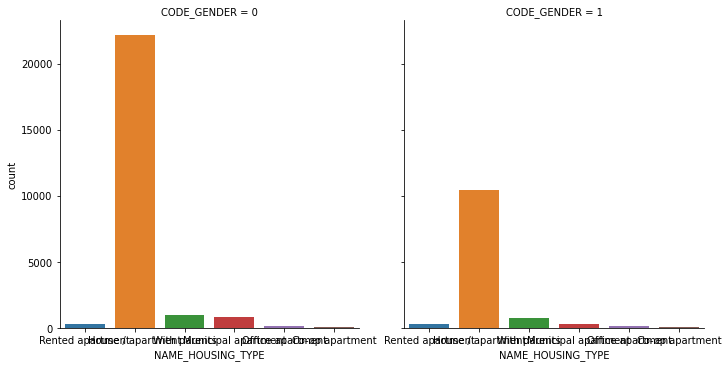

In [59]:
p_who_own_house = application_record.select(col('CODE_GENDER'),col('NAME_HOUSING_TYPE')).toPandas()
sns.catplot(x='NAME_HOUSING_TYPE',kind="count",col='CODE_GENDER', data = p_who_own_house,legend=True)
plt.xticks(rotation=90)
plt.show()

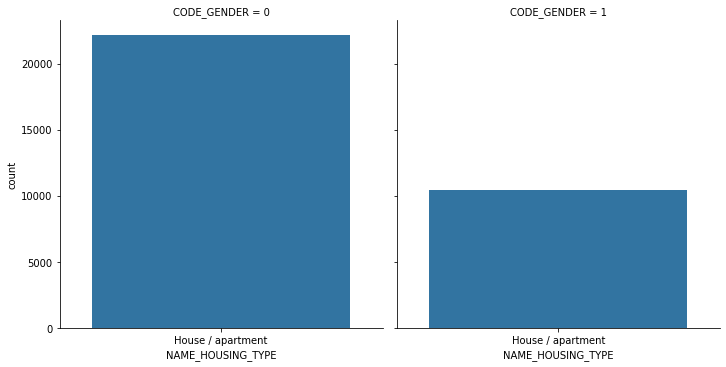

In [60]:
p_who_own_house = application_record.filter(col('NAME_HOUSING_TYPE') == "House / apartment").select(col('CODE_GENDER'),col('NAME_HOUSING_TYPE')).toPandas()
sns.catplot(x='NAME_HOUSING_TYPE',kind="count",col='CODE_GENDER', data = p_who_own_house,legend=True)
plt.show()

*Based on the above graphs we can see that majority of our applicants are married and own's a house/appartment.*

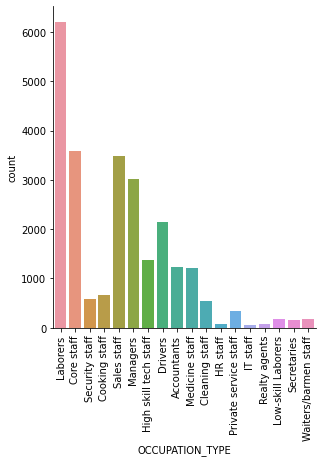

In [61]:
sns.catplot(x='OCCUPATION_TYPE', kind="count", data = p_non_binary_categorical_columns_df,legend=True)
plt.xticks(rotation=90)
plt.show()

*Even thought there are many missing rows, we can see the the segrigation among categories is good even though those are not equally distributed.*

### Let us look into sequential features and we will do multi-variate analysis on all the features.

In [62]:
sequental_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']

In [63]:
p_application_record = application_record.toPandas()

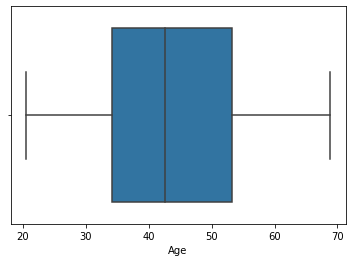

In [64]:
ax = sns.boxplot(data = p_application_record, x = abs(p_application_record['DAYS_BIRTH']/365.25))
ax.set(xlabel='Age')
plt.show()

In [65]:
from pyspark.sql.types import IntegerType
application_record = application_record.withColumn('AGE',(-application_record.DAYS_BIRTH/365.25).cast(IntegerType()))
application_record = application_record.drop('DAYS_BIRTH')

In [66]:
p_application_record = application_record.toPandas()

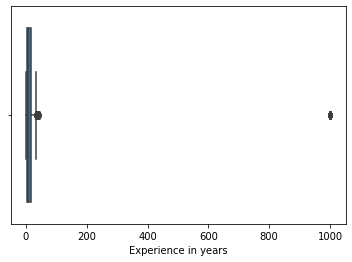

In [67]:
ax = sns.boxplot(data = p_application_record, x = abs(p_application_record['DAYS_EMPLOYED']/365))
ax.set(xlabel='Experience in years')
plt.show()

*Birth days (age) looks good, but days employed (years of experience) looks invalid. Let's see the outlier data*

In [68]:
application_record.select(col('DAYS_EMPLOYED')).describe().show()

[Stage 229:=================================================>   (187 + 4) / 200]

+-------+------------------+
|summary|     DAYS_EMPLOYED|
+-------+------------------+
|  count|             36457|
|   mean|59262.935567929344|
| stddev| 137651.3348588565|
|    min|            -15713|
|    max|            365243|
+-------+------------------+



We can see that max value is positive. But there should not be any positive values as our data is considered as past number of days working from current date.We will not drop these rows as these are important, we will exclude these rows to see the experience range.

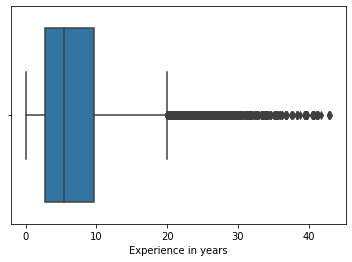

In [69]:
p_experience_df = application_record.filter(col('DAYS_EMPLOYED') != 365243).toPandas()
ax = sns.boxplot(data = p_experience_df, x = abs(p_experience_df['DAYS_EMPLOYED']/365))
ax.set(xlabel='Experience in years')
plt.show()

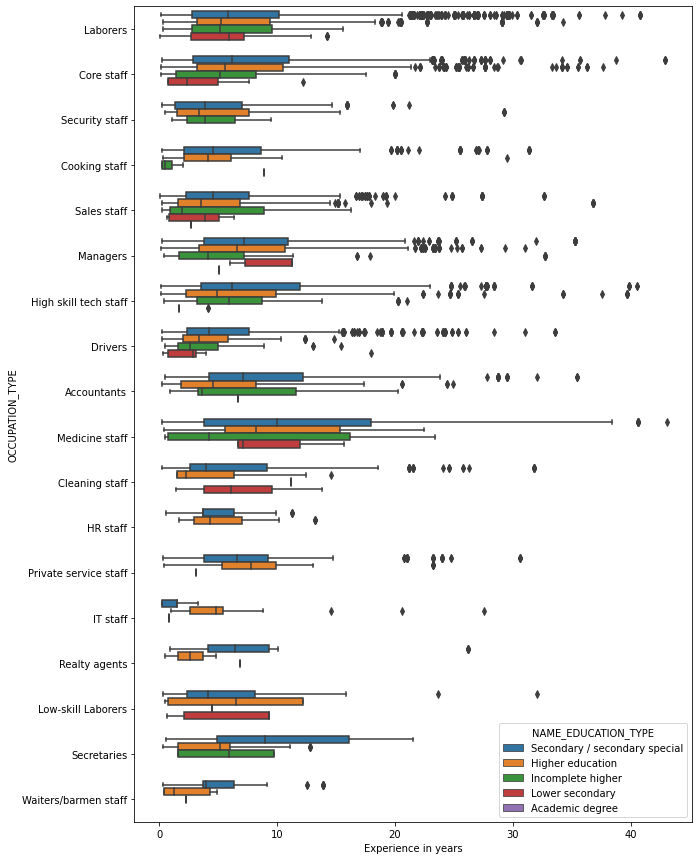

In [70]:
#Lets see the experience based on occupation and education type
p_experience_df = application_record.filter(col('DAYS_EMPLOYED') != 365243).toPandas()
plt.figure(figsize=[10,15])
ax = sns.boxplot(data = p_experience_df, x = abs(p_experience_df['DAYS_EMPLOYED']/365), y = 'OCCUPATION_TYPE', hue='NAME_EDUCATION_TYPE')
ax.set(xlabel='Experience in years')
plt.show()

This bar graph is clearly showing which occupation has max and min number of years of experience and from which education type background.

In [71]:
application_record.filter(col('DAYS_EMPLOYED') == 365243).toPandas().head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,delinquent,AGE
0,5009581,0,0,0,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,0,0,0,None,2.0,0,58
1,5018505,0,0,0,0,58500.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,0,0,0,None,2.0,0,57
2,5023251,0,0,1,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,0,0,0,None,2.0,0,53
3,5024600,0,0,1,0,630000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,365243,0,1,0,None,1.0,0,60
4,5024789,0,0,1,0,225000.0,Pensioner,Higher education,Married,House / apartment,365243,0,0,0,None,2.0,0,65


*For all the application records whose days employed is 365243 have OCCUPATION_TYPE None, which says that 365243 is actually a null category.*
*To prove our analysis, lets see if there is any Non-null OCCUPATION_TYPE whose days employed is 365243*

In [72]:
application_record.filter((col('DAYS_EMPLOYED') == 365243) & (col('OCCUPATION_TYPE').isNotNull())).count()

0

If they are unemployed what is their income type. Van they be Pensioner. Lets try to see that.

In [73]:
print("Unemployed ppl with days of employment 365243: ",application_record.filter((col('DAYS_EMPLOYED') == 365243) & (col('OCCUPATION_TYPE').isNull())).count())
print("Pensioner with days of employment 365243: ", application_record.filter((col('DAYS_EMPLOYED') == 365243) & (col('NAME_INCOME_TYPE') == "Pensioner")).count())
print("Not Pensioner with days of employment 365243: ", application_record.filter((col('DAYS_EMPLOYED') == 365243) & (col('NAME_INCOME_TYPE') != "Pensioner")).count())

Unemployed ppl with days of employment 365243:  6135


Pensioner with days of employment 365243:  6135


[Stage 268:=======================================>             (149 + 5) / 200]

Not Pensioner with days of employment 365243:  0


In [74]:
application_record.filter((col('DAYS_EMPLOYED') != 365243) & (col('NAME_INCOME_TYPE') == "Pensioner")).toPandas().head(50)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,delinquent,AGE
0,5009753,0,1,0,0,315000.0,Pensioner,Higher education,Married,House / apartment,-586,1,1,0,None,2.0,1,37
1,5054386,1,1,0,0,292500.0,Pensioner,Higher education,Single / not married,House / apartment,-3680,1,1,0,Laborers,1.0,1,38
2,5092394,1,1,1,1,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-443,1,0,0,Drivers,3.0,1,30
3,5046328,0,0,1,1,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-2269,0,1,0,Low-skill Laborers,3.0,1,42
4,5105739,0,0,1,3,292500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-672,0,0,0,Core staff,5.0,1,33
5,5118648,0,0,1,2,270000.0,Pensioner,Higher education,Single / not married,House / apartment,-2745,0,0,0,Core staff,3.0,1,28
6,5148694,0,0,0,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,-198,0,0,0,Laborers,2.0,1,56
7,5116907,1,1,1,0,211500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-7553,0,0,0,Core staff,2.0,1,41
8,5021998,1,0,1,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-1644,0,0,1,None,2.0,1,51
9,5149838,0,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,-1325,0,1,1,Medicine staff,2.0,1,33


*We can see that whoe ever is having DAYS_EMPLOYED as 365243 are all Pensioner. So, lets add a category Retired.*

**But we also have some records who are Pensioner and have different kind of occupation types including 4 with no occupation. We will leave those records as it is for now. 
They are all delinquent. So these details are preety important.**

In [75]:
#Lets add a category of unemployed when days employed is 365243
application_record = application_record.withColumn("OCCUPATION_TYPE", when(application_record.DAYS_EMPLOYED == 365243,"Retired").otherwise(application_record.OCCUPATION_TYPE))
p_application_record = application_record.toPandas()

Lets, see how many more rows do we have without occupation type.

In [76]:
application_record.filter((col('OCCUPATION_TYPE').isNull())).count()

5188

In [77]:
application_record.filter((col('OCCUPATION_TYPE').isNull())).toPandas().head(50)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,delinquent,AGE
0,5010672,0,0,1,1,157500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-8714,0,0,0,None,3.0,0,42
1,5021574,1,0,0,0,270000.0,State servant,Incomplete higher,Married,House / apartment,-1674,0,0,0,None,2.0,0,26
2,5021979,0,0,0,1,180000.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-2013,0,0,1,None,2.0,0,35
3,5022016,1,1,1,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-1613,0,0,0,None,1.0,0,27
4,5028783,0,0,1,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-3034,0,0,0,None,2.0,0,43
5,5146462,1,1,0,0,360000.0,State servant,Higher education,Married,House / apartment,-1923,0,0,0,None,2.0,0,27
6,5037137,0,0,1,0,144000.0,State servant,Higher education,Married,House / apartment,-4449,0,0,0,None,2.0,0,51
7,5044486,0,1,1,0,135000.0,Working,Secondary / secondary special,Widow,House / apartment,-1407,0,0,0,None,1.0,0,45
8,5044756,0,0,1,1,121500.0,Working,Incomplete higher,Single / not married,House / apartment,-1621,0,0,0,None,2.0,0,37
9,5051035,0,0,0,0,180000.0,Commercial associate,Higher education,Single / not married,With parents,-1017,0,0,0,None,1.0,0,24


*We will replace ther remaining nan values with Other. and convert the DAYS_EMPLOYED to YEARS_OF_EXPERIENCE.*

In [78]:
application_record = application_record.fillna('Other', subset='OCCUPATION_TYPE')

In [79]:
application_record = application_record.withColumn('YEARS_OF_EXPERIENCE',when(application_record.DAYS_EMPLOYED != 365243,-application_record.DAYS_EMPLOYED/365.25).otherwise(0).cast(IntegerType()))
application_record = application_record.drop('DAYS_EMPLOYED')

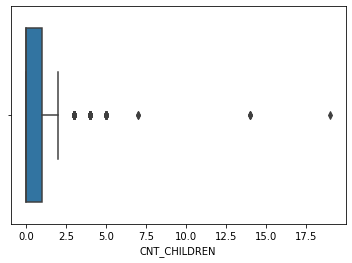

In [80]:
sns.boxplot(data = p_application_record, x = p_application_record['CNT_CHILDREN'])
plt.show()

Normally we assume that people with higher education hava a better family planning. Let's see from which education level we are getting the outlaiers. 

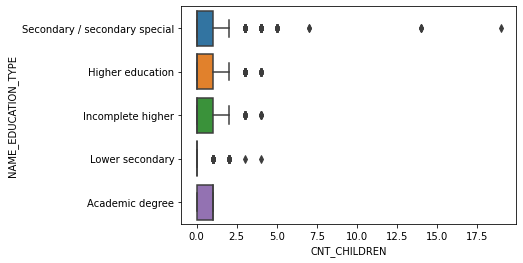

In [81]:
sns.boxplot(data = p_application_record, x = p_application_record['CNT_CHILDREN'],y=p_application_record['NAME_EDUCATION_TYPE'])
plt.show()

*We are seeing the huge outliers from secondary/secondary special education level, other than that, every other category looks similar.*

In [82]:
application_record.filter(col('CNT_CHILDREN') >= 5).show()

+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+----------+---+-------------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|delinquent|AGE|YEARS_OF_EXPERIENCE|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+----------+---+-------------------+
|5105607|          0|           0|              1|           5|        157500.0|         Working|Secondary / secon...|           Married|House / apartment|              0|         0|         0|       Laborers|        

Let us see how is the children count with OCCUPATION_TYPE

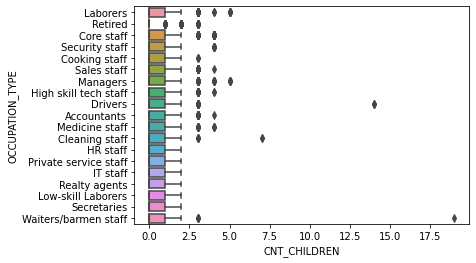

In [83]:
sns.boxplot(data = p_application_record, x = p_application_record['CNT_CHILDREN'],y=p_application_record['OCCUPATION_TYPE'])
plt.show()

*Even though the 50 and 95 percential is same for all  occupation types, we can see that the higher outlaiers are from low level occupations.*


*We can alse see that manjority of Retired people does not have childeren. It doesn't look correct. Lets see about it.*

In [84]:
p_application_record[p_application_record['OCCUPATION_TYPE'] == 'Retired'].describe(percentiles=[.25, .5, .75, .90, .95,.96,.97,.98, .99])

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,delinquent,AGE
count,6.135000e+03,6135.000000,6135.000000,6135.000000,6135.000000,6135.000000,6135.0,6135.0,6135.000000,6135.000000,6135.000000,6135.000000,6135.000000
mean,5.074650e+06,0.146699,0.209780,0.769356,0.050204,148590.916137,365243.0,0.0,0.288183,0.034882,1.748655,0.018419,59.092095
std,4.173749e+04,0.353835,0.407185,0.421279,0.282790,76593.371512,0.0,0.0,0.452953,0.183495,0.556613,0.134472,5.312181
min,5.008812e+06,0.000000,0.000000,0.000000,0.000000,29250.000000,365243.0,0.0,0.000000,0.000000,1.000000,0.000000,22.000000
25%,5.038624e+06,0.000000,0.000000,1.000000,0.000000,94500.000000,365243.0,0.0,0.000000,0.000000,1.000000,0.000000,57.000000
50%,5.067042e+06,0.000000,0.000000,1.000000,0.000000,135000.000000,365243.0,0.0,0.000000,0.000000,2.000000,0.000000,60.000000
75%,5.113456e+06,0.000000,0.000000,1.000000,0.000000,180000.000000,365243.0,0.0,1.000000,0.000000,2.000000,0.000000,63.000000
90%,5.137418e+06,1.000000,1.000000,1.000000,0.000000,225000.000000,365243.0,0.0,1.000000,0.000000,2.000000,0.000000,65.000000
95%,5.143480e+06,1.000000,1.000000,1.000000,0.000000,292500.000000,365243.0,0.0,1.000000,0.000000,2.000000,0.000000,66.000000
96%,5.145897e+06,1.000000,1.000000,1.000000,0.000000,292500.000000,365243.0,0.0,1.000000,0.000000,2.000000,0.000000,66.000000


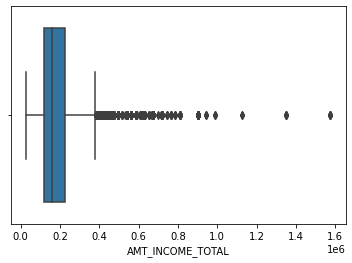

In [85]:
sns.boxplot(data = p_application_record, x = p_application_record['AMT_INCOME_TOTAL'])
plt.show()

In [86]:
import pyspark.sql.functions as F
application_record.select(col('AMT_INCOME_TOTAL')).describe().show()
application_record.agg(F.expr('percentile(AMT_INCOME_TOTAL, array(0.25))')[0].alias('%25'),
                             F.expr('percentile(AMT_INCOME_TOTAL, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(AMT_INCOME_TOTAL, array(0.75))')[0].alias('%75')).show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|             36457|
|   mean|186685.73666236937|
| stddev| 101789.2264823466|
|    min|           27000.0|
|    max|         1575000.0|
+-------+------------------+



[Stage 312:==============================================>      (176 + 4) / 200]

+--------+--------+--------+
|     %25|     %50|     %75|
+--------+--------+--------+
|121500.0|157500.0|225000.0|
+--------+--------+--------+



In [87]:
application_record_complete.select(col('AMT_INCOME_TOTAL')).describe().show()
application_record_complete.agg(F.expr('percentile(AMT_INCOME_TOTAL, array(0.25))')[0].alias('%25'),
                             F.expr('percentile(AMT_INCOME_TOTAL, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(AMT_INCOME_TOTAL, array(0.75))')[0].alias('%75')).show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            438557|
|   mean| 187524.2860095039|
| stddev|110086.85306622942|
|    min|           26100.0|
|    max|         6750000.0|
+-------+------------------+



[Stage 323:==============>                                          (1 + 3) / 4]

+--------+--------+--------+
|     %25|     %50|     %75|
+--------+--------+--------+
|121500.0|160780.5|225000.0|
+--------+--------+--------+



*In a complte applications as well as application who hold the credit card already, we can see that mean and median are preety much same.*

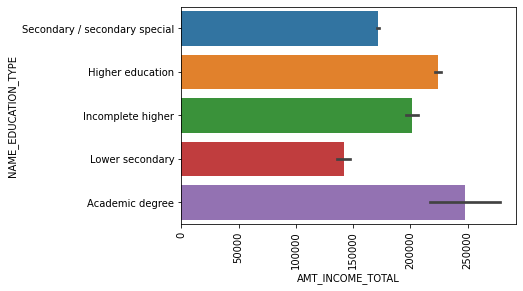

In [88]:
sns.barplot(data = p_application_record, x = p_application_record['AMT_INCOME_TOTAL'],y=p_application_record['NAME_EDUCATION_TYPE'])
plt.xticks(rotation=90)
plt.show()

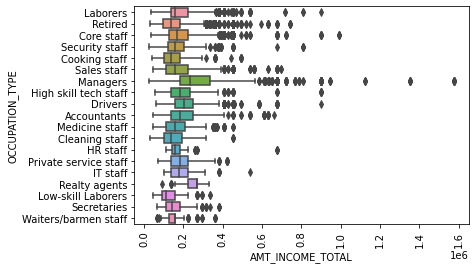

In [89]:
sns.boxplot(data = p_application_record, x = p_application_record['AMT_INCOME_TOTAL'],y=p_application_record['OCCUPATION_TYPE'])
plt.xticks(rotation=90)
plt.show()

In [90]:
application_record.filter(col('AMT_INCOME_TOTAL') > 1000000).count()

17

Let us see where do these people who earn more than 1000000 stay

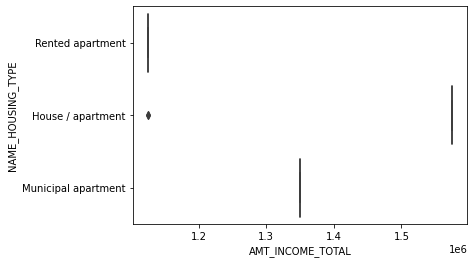

In [91]:
p_hign_income_df = application_record.filter(col('AMT_INCOME_TOTAL') > 1000000).toPandas()
sns.boxplot(data = p_hign_income_df, x = p_hign_income_df['AMT_INCOME_TOTAL'],y=p_hign_income_df['NAME_HOUSING_TYPE'])
plt.show()

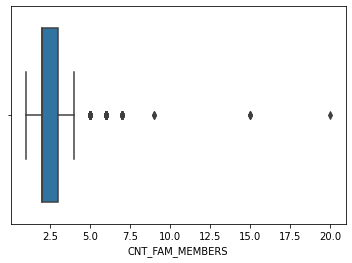

In [92]:
sns.boxplot(data = p_application_record, x = p_application_record['CNT_FAM_MEMBERS'])
plt.show()

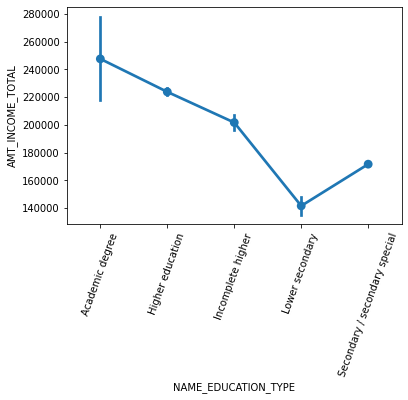

In [93]:
#Is there any correlation between the customer's income level and education level?
sns.pointplot(x="NAME_EDUCATION_TYPE", y="AMT_INCOME_TOTAL", data=p_application_record.sort_values('NAME_EDUCATION_TYPE'))
degrees = 70  
plt.xticks(rotation=degrees)
plt.show()

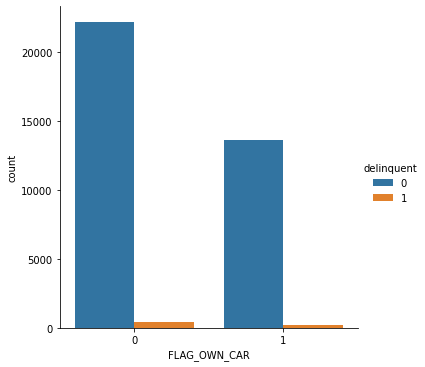

In [94]:
#Is the proportion of bad customers higher for people who own cars?
p_flag_own_car_bad_vs_good_proportion = application_record.select(col('FLAG_OWN_CAR'),col('delinquent')).toPandas()
sns.catplot(x='FLAG_OWN_CAR',hue='delinquent', kind="count", data = p_flag_own_car_bad_vs_good_proportion,legend=True)
plt.show()

The bad customers in our case is who have delinquent to 1. To answer the sepculation _Is the proportion of bad customers higher for people who own cars?_


No, As we can see in the graph, the customers who are delinquent is very less compared to the ones who don't.

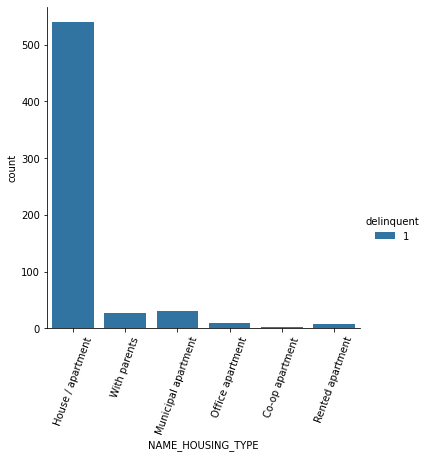

In [95]:
#Is the proportion of bad customers higher for those living on rent than the rest of the population?
p_bad_customers_based_on_housign_type = application_record.filter(col('delinquent') == 1).select(col('NAME_HOUSING_TYPE'),col('delinquent')).toPandas()
sns.catplot(x='NAME_HOUSING_TYPE',hue='delinquent', kind="count", data = p_bad_customers_based_on_housign_type,legend=True)
degrees = 70  
plt.xticks(rotation=degrees)
plt.show()

The speculation _Is the proportion of bad customers higher for those living on rent than the rest of the population?_ is actually wrong. As we can see the bad customers are higher from own House/apartment than rented ones.

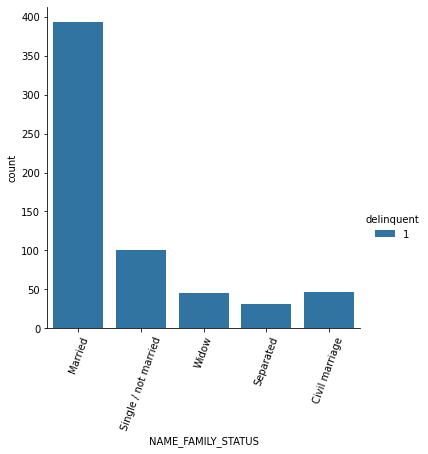

In [96]:
#Is the proportion of bad customers higher for those who are single than married customers?
p_customers_who_are_single_currently = application_record.filter(col('delinquent') == 1).select(col('NAME_FAMILY_STATUS'),col('delinquent')).toPandas()
sns.catplot(x='NAME_FAMILY_STATUS',hue='delinquent', kind="count", data = p_customers_who_are_single_currently,legend=True)
plt.xticks(rotation=70)
plt.show()

This can be seen in two ways, either ppl who are not at all married or they are currently single. In both the cases the assumption is wrong. The delinquent customers are more in married category than any other.

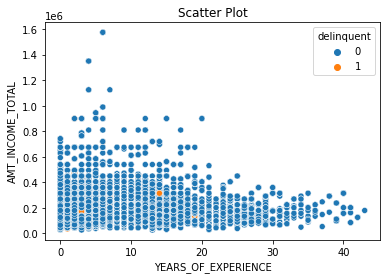

In [98]:
p_Income_Years = application_record.select(col('YEARS_OF_EXPERIENCE'),col('AMT_INCOME_TOTAL'),col('delinquent')).toPandas()
sns.scatterplot(p_Income_Years['YEARS_OF_EXPERIENCE'], p_Income_Years['AMT_INCOME_TOTAL'], hue=p_Income_Years['delinquent'])
plt.title('Scatter Plot')
plt.show()

This graph shows that, majority of applications are rejected if Total income & years of Employment is less

**At this point we have an idea on each feature available in dataset and how is the data segrigated and how are they related to each other. Now, we will do feature selection.**

## Feature validations and selections

In [101]:
application_record.toPandas().to_csv("output.csv",index=False)

In [102]:
application_record = sqlContext.read.csv('output.csv', header=True, inferSchema=True)
p_application_record = application_record.toPandas()

In [103]:
application_record.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: integer (nullable = true)
 |-- FLAG_OWN_CAR: integer (nullable = true)
 |-- FLAG_OWN_REALTY: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- delinquent: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- YEARS_OF_EXPERIENCE: integer (nullable = true)



In [104]:
from pyspark.sql.types import IntegerType
application_record = application_record.withColumn('CNT_FAM_MEMBERS',col('CNT_FAM_MEMBERS').cast(IntegerType()))

In [105]:
p_application_record.drop('ID', axis=1, inplace=True)

In [106]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()] #Get all the rows with null X values (It will be empty as there are no missing values in out categorical columns.)
    notmiss = df1[['X','Y']][df1.X.notnull()] #get all the rows with X values
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    df3 = pd.DataFrame({},index=[])
    df3["MIN_VALUE"] = d2.min().X
    df3["MAX_VALUE"] = d2.max().X
    df3["COUNT"] = d2.count().Y
    df3["EVENT"] = d2.sum().Y
    df3["NONEVENT"] = d2.count().Y - d2.sum().Y
    df3=df3.reset_index(drop=True)
    
    #If there are are any null values, in a partucalt column, this if block add the row for that.
    if len(justmiss.index) > 0:
        df4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        df4["MAX_VALUE"] = np.nan
        df4["COUNT"] = justmiss.count().Y
        df4["EVENT"] = justmiss.sum().Y
        df4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        df3 = df3.append(df4,ignore_index=True)
    
    df3["EVENT_RATE"] = df3.EVENT/df3.COUNT
    df3["NON_EVENT_RATE"] = df3.NONEVENT/df3.COUNT
    df3["DIST_EVENT"] = df3.EVENT/df3.sum().EVENT
    df3["DIST_NON_EVENT"] = df3.NONEVENT/df3.sum().NONEVENT
    #In this case the good customers are those with delinquent 0 and bad customers are with delinquence 1.
    # Which is same as NONEVENT are good customers and events are bad customers
    df3["WOE"] = np.log(df3.DIST_NON_EVENT/df3.DIST_EVENT)
    df3["IV"] = (df3.DIST_NON_EVENT-df3.DIST_EVENT)*np.log(df3.DIST_NON_EVENT/df3.DIST_EVENT)
    df3["VAR_NAME"] = "VAR"
    df3 = df3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    df3 = df3.replace([np.inf, -np.inf], 0)
    df3['FEATURE_IV'] = df3.IV.sum()
    
    return(df3)

def char_bin(Y, X):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()] #Get all the rows with null X values
    notmiss = df1[['X','Y']][df1.X.notnull()] #Get all the rows with X values
    df2 = notmiss.groupby('X',as_index=True)
    
    df3 = pd.DataFrame({},index=[])
    df3["COUNT"] = df2.count().Y
    df3["MIN_VALUE"] = df2.sum().Y.index
    df3["MAX_VALUE"] = df3["MIN_VALUE"]
    df3["EVENT"] = df2.sum().Y
    df3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    #If there are are any null values, in a partucalt column, this if block add the row for that.
    if len(justmiss.index) > 0:
        df4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        df4["MAX_VALUE"] = np.nan
        df4["COUNT"] = justmiss.count().Y
        df4["EVENT"] = justmiss.sum().Y
        df4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        df3 = df3.append(df4,ignore_index=True)
    
    df3["EVENT_RATE"] = df3.EVENT/df3.COUNT
    df3["NON_EVENT_RATE"] = df3.NONEVENT/df3.COUNT
    df3["DIST_EVENT"] = df3.EVENT/df3.sum().EVENT
    df3["DIST_NON_EVENT"] = df3.NONEVENT/df3.sum().NONEVENT
    #In this case the good customers are those with delinquent 0 and bad customers are with delinquence 1.
    # Which is same as NONEVENT are good customers and events are bad customers
    df3["WOE"] = np.log(df3.DIST_NON_EVENT/df3.DIST_EVENT)
    df3["IV"] = (df3.DIST_NON_EVENT-df3.DIST_EVENT)*np.log(df3.DIST_NON_EVENT/df3.DIST_EVENT)
    df3["VAR_NAME"] = "VAR"
    df3 = df3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    df3 = df3.replace([np.inf, -np.inf], 0)
    df3['FEATURE_IV'] = df3.IV.sum()
    df3 = df3.reset_index(drop=True)
    
    return(df3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').FEATURE_IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [107]:
p_application_record_iv, IV = data_vars(p_application_record,p_application_record.delinquent)

In [108]:
p_application_record_iv.head(50)

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV,FEATURE_IV
0,CODE_GENDER,0.0,0.0,24430,379,0.015514,24051,0.984486,0.615260,0.671047,0.086795,0.004842,0.013581
1,CODE_GENDER,1.0,1.0,12027,237,0.019706,11790,0.980294,0.384740,0.328953,-0.156654,0.008739,0.013581
2,FLAG_OWN_CAR,0.0,0.0,22614,392,0.017334,22222,0.982666,0.636364,0.620016,-0.026025,0.000425,0.001144
3,FLAG_OWN_CAR,1.0,1.0,13843,224,0.016181,13619,0.983819,0.363636,0.379984,0.043974,0.000719,0.001144
4,FLAG_OWN_REALTY,0.0,0.0,11951,251,0.021002,11700,0.978998,0.407468,0.326442,-0.221710,0.017964,0.028349
5,FLAG_OWN_REALTY,1.0,1.0,24506,365,0.014894,24141,0.985106,0.592532,0.673558,0.128169,0.010385,0.028349
6,CNT_CHILDREN,0.0,1.0,32693,551,0.016854,32142,0.983146,0.894481,0.896794,0.002583,0.000006,0.000057
7,CNT_CHILDREN,2.0,19.0,3764,65,0.017269,3699,0.982731,0.105519,0.103206,-0.022170,0.000051,0.000057
8,AMT_INCOME_TOTAL,27000.0,157500.0,18563,306,0.016484,18257,0.983516,0.496753,0.509389,0.025118,0.000317,0.000639
9,AMT_INCOME_TOTAL,159750.0,1575000.0,17894,310,0.017324,17584,0.982676,0.503247,0.490611,-0.025428,0.000321,0.000639


In [109]:
IV.sort_values('IV')

,VAR_NAME,IV
0,AGE,0.000042
2,CNT_CHILDREN,0.000057
8,FLAG_PHONE,0.000150
3,CNT_FAM_MEMBERS,0.000357
5,FLAG_EMAIL,0.000366
1,AMT_INCOME_TOTAL,0.000639
6,FLAG_OWN_CAR,0.001144
9,FLAG_WORK_PHONE,0.001865
10,NAME_EDUCATION_TYPE,0.009209
4,CODE_GENDER,0.013581


As most of the feature are lest that 0.02, we will use the 0.002 as a threshold.
That means, any feature whose IV is less that 0.02 is insignificat and we can ingore those features for model building.

We can see that the occupation type and family status have more predictive capacity.Two of the important features. So, let us see how many deliquent customer do we have in each category. 

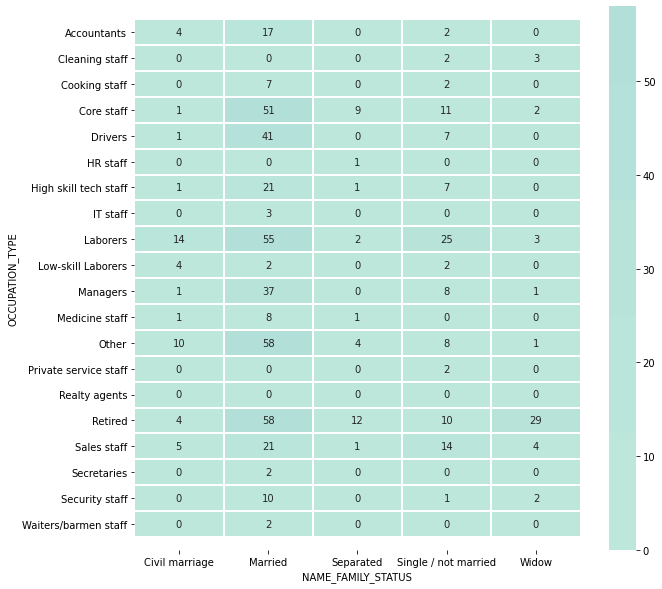

In [110]:
occ_type_pvt_tbl = pd.pivot_table(data = p_application_record, index = ['OCCUPATION_TYPE'], columns = ['NAME_FAMILY_STATUS'], values = 'delinquent', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,10])
hm = sns.heatmap(data = occ_type_pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Overall we can see that the delinquency is more from Married people.

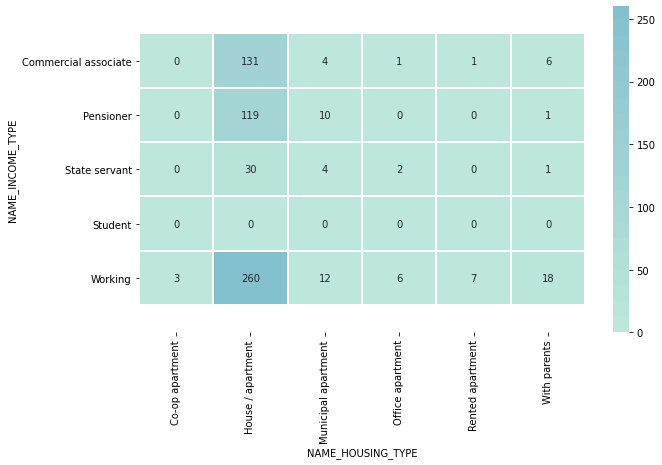

In [111]:
#Next two importnt categorical columsn are housing type and income type. So, let us see how many deliqnent customers.
pvt_tbl = pd.pivot_table(data = p_application_record, index = ['NAME_INCOME_TYPE'], columns = ['NAME_HOUSING_TYPE'], values = 'delinquent', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,6])
hm = sns.heatmap(data = pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Overall we can see that the delinquency is more from ppl who own house/rent. 

In [112]:
selected_features = IV[IV.IV >= 0.002]['VAR_NAME']

In [113]:
selected_features

4             CODE_GENDER
7         FLAG_OWN_REALTY
10    NAME_EDUCATION_TYPE
11     NAME_FAMILY_STATUS
12      NAME_HOUSING_TYPE
13       NAME_INCOME_TYPE
14        OCCUPATION_TYPE
15    YEARS_OF_EXPERIENCE
Name: VAR_NAME, dtype: object

From the selected features, let us transform categorical variables with WOE.

In [114]:
from itertools import chain
from pyspark.sql.functions import create_map, lit

In [115]:
cat_cols = list(p_application_record.select_dtypes(include=['object']).columns)

In [116]:
application_record_backup = application_record

In [117]:
for column in cat_cols:
    woe_df = p_application_record_iv[p_application_record_iv['VAR_NAME'] == column]
    transform_dict = dict(zip(woe_df.MAX_VALUE,woe_df.WOE))
    woe_lol= list(map(list, transform_dict.items()))
    woe_df_for_column = spark.createDataFrame(woe_lol, [column, "WOE_"+column]) 
    application_record = application_record.join(woe_df_for_column, on=column, how='left')

In [118]:
application_record.printSchema()

root
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: integer (nullable = true)
 |-- FLAG_OWN_CAR: integer (nullable = true)
 |-- FLAG_OWN_REALTY: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: integer (nullable = true)
 |-- delinquent: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- YEARS_OF_EXPERIENCE: integer (nullable = true)
 |-- WOE_NAME_INCOME_TYPE: double (nullable = true)
 |-- WOE_NAME_EDUCATION_TYPE: double (nullable = true)
 |-- WOE_NAME_FAMILY_STATUS: double (nullable = true)
 |-- WOE_NA

*Now that we have have filterd the features based on IV and we have added respective selected features with it's woe values. let us build the initiali model and see how it performs. But, before that let's see the correlation beterrn columns.*

In [119]:
cols_for_model = ['CODE_GENDER','YEARS_OF_EXPERIENCE','FLAG_OWN_REALTY','WOE_NAME_EDUCATION_TYPE','WOE_NAME_FAMILY_STATUS',
                 'WOE_NAME_FAMILY_STATUS','WOE_NAME_HOUSING_TYPE','WOE_NAME_HOUSING_TYPE','WOE_OCCUPATION_TYPE',
                 'delinquent']

In [120]:
p_application_record = application_record.toPandas()

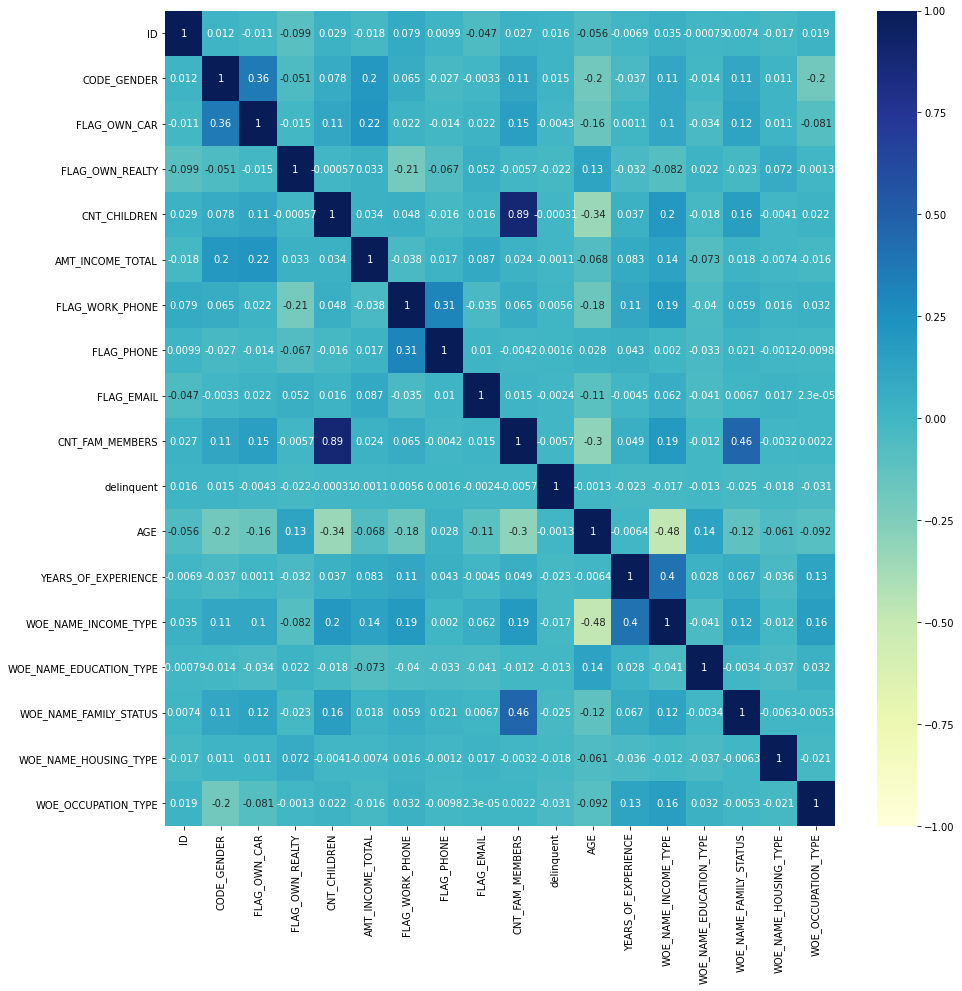

In [121]:
corr = p_application_record.corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="YlGnBu", annot=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [122]:
application_record_for_model_building = application_record.select(*cols_for_model)

In [123]:
cols_for_model.remove('delinquent')

In [124]:
cols_for_model

['CODE_GENDER',
 'YEARS_OF_EXPERIENCE',
 'FLAG_OWN_REALTY',
 'WOE_NAME_EDUCATION_TYPE',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_OCCUPATION_TYPE']

In [125]:
independent_cols = cols_for_model 

In [126]:
target_col = 'delinquent'

In [127]:
independent_cols

['CODE_GENDER',
 'YEARS_OF_EXPERIENCE',
 'FLAG_OWN_REALTY',
 'WOE_NAME_EDUCATION_TYPE',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_OCCUPATION_TYPE']

## Model Building

### But the model with independent_cols 

In [128]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

In [129]:
assembler = VectorAssembler(inputCols=independent_cols, outputCol='ss_features')
application_record_for_model_building = assembler.transform(application_record_for_model_building)

In [130]:
#Scale all the features.
standard_scalar = StandardScaler(inputCol='ss_features',outputCol='features')

In [131]:
application_record_for_model_building = standard_scalar.fit(application_record_for_model_building).transform(application_record_for_model_building)

In [132]:
train, test = application_record_for_model_building.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 25671


[Stage 415:===================================================> (195 + 4) / 200]

Test Dataset Count: 10786


In [133]:
train.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|  440|
|         0|25231|
+----------+-----+



In [134]:
test.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|  176|
|         0|10610|
+----------+-----+



In [135]:
lr = LogisticRegression(featuresCol='features', labelCol=target_col)
model = lr.fit(train)

21/07/13 13:36:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/07/13 13:36:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [136]:
train_result = model.evaluate(train)

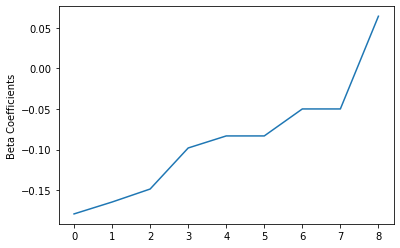

In [137]:
#Coefficients of 8 features sorted.
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

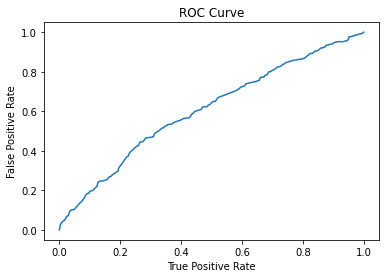

Training set areaUnderROC: 0.605742620009296


In [138]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [139]:
y_true = train_result.predictions.select(['delinquent']).collect()
y_pred = train_result.predictions.select(['prediction']).collect()

In [140]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25231
           1       0.00      0.00      0.00       440

    accuracy                           0.98     25671
   macro avg       0.49      0.50      0.50     25671
weighted avg       0.97      0.98      0.97     25671



In [141]:
#evlautate the data using the evaluate method. 
test_result = model.transform(test)

In [142]:
y_true = test_result.select(['delinquent']).collect()
y_pred = test_result.select(['prediction']).collect()

In [143]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10610
           1       0.00      0.00      0.00       176

    accuracy                           0.98     10786
   macro avg       0.49      0.50      0.50     10786
weighted avg       0.97      0.98      0.98     10786



#### Overall this is a bad model, it literally predicts all 0. May be it is becuase of highly imbalanced. 

### Let us try to add the weights to delinquent.

In [144]:
cols_for_model = ['CODE_GENDER','YEARS_OF_EXPERIENCE','FLAG_OWN_REALTY','WOE_NAME_EDUCATION_TYPE','WOE_NAME_FAMILY_STATUS',
                 'WOE_NAME_FAMILY_STATUS','WOE_NAME_HOUSING_TYPE','WOE_NAME_HOUSING_TYPE','WOE_OCCUPATION_TYPE',
                 'delinquent']

In [145]:
application_record_for_model_building = application_record.select(*cols_for_model)

In [146]:
cols_for_model.remove('delinquent')
independent_cols = cols_for_model 

In [147]:
independent_cols

['CODE_GENDER',
 'YEARS_OF_EXPERIENCE',
 'FLAG_OWN_REALTY',
 'WOE_NAME_EDUCATION_TYPE',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_FAMILY_STATUS',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_NAME_HOUSING_TYPE',
 'WOE_OCCUPATION_TYPE']

In [148]:
assembler = VectorAssembler(inputCols=independent_cols, outputCol='ss_features')
application_record_for_model_building = assembler.transform(application_record_for_model_building)
standard_scalar = StandardScaler(inputCol='ss_features',outputCol='features')
application_record_for_model_building = standard_scalar.fit(application_record_for_model_building).transform(application_record_for_model_building)

In [149]:
train, test = application_record_for_model_building.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 25671
Test Dataset Count: 10786


In [150]:
train.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|  440|
|         0|25231|
+----------+-----+



In [151]:
test.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|  176|
|         0|10610|
+----------+-----+



In [152]:
ratioOfFraud = train.filter(col('delinquent') == 1).count()/train.count()
fraudWeight  = 1 - ratioOfFraud
nonFraudWeight = ratioOfFraud

In [153]:
print("ratioOfFraud:", ratioOfFraud)
print("fraudWeight:", fraudWeight)
print("nonFraudWeight:",nonFraudWeight)

ratioOfFraud: 0.0171399633828055
fraudWeight: 0.9828600366171945
nonFraudWeight: 0.0171399633828055


In [154]:
train = train.withColumn("WEIGHT",
      when(col("delinquent")==(1),fraudWeight)
     .otherwise(nonFraudWeight))

In [155]:
lr = LogisticRegression(featuresCol='features', labelCol=target_col)
lr.setWeightCol("WEIGHT")
model = lr.fit(train)

In [156]:
train_result = model.evaluate(train)

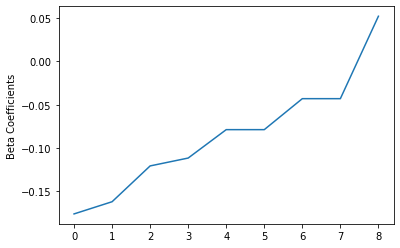

In [157]:
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

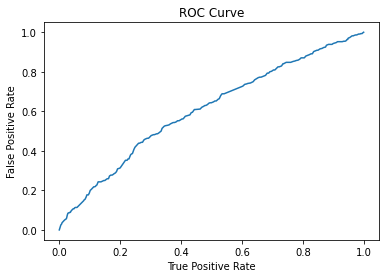

Training set areaUnderROC: 0.6063281190887111


In [158]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [159]:
y_true = train_result.predictions.select(['delinquent']).collect()
y_pred = train_result.predictions.select(['prediction']).collect()

In [160]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.61      0.76     25231
           1       0.02      0.55      0.05       440

    accuracy                           0.61     25671
   macro avg       0.51      0.58      0.40     25671
weighted avg       0.97      0.61      0.74     25671



In [161]:
test_result = model.transform(test)

In [162]:
y_true = test_result.select(['delinquent']).collect()
y_pred = test_result.select(['prediction']).collect()

In [163]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75     10610
           1       0.02      0.52      0.04       176

    accuracy                           0.61     10786
   macro avg       0.50      0.57      0.40     10786
weighted avg       0.97      0.61      0.74     10786



In [164]:
test_result.show(5)

+-----------+-------------------+---------------+-----------------------+----------------------+----------------------+---------------------+---------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|CODE_GENDER|YEARS_OF_EXPERIENCE|FLAG_OWN_REALTY|WOE_NAME_EDUCATION_TYPE|WOE_NAME_FAMILY_STATUS|WOE_NAME_FAMILY_STATUS|WOE_NAME_HOUSING_TYPE|WOE_NAME_HOUSING_TYPE|WOE_OCCUPATION_TYPE|delinquent|         ss_features|            features|       rawPrediction|         probability|prediction|
+-----------+-------------------+---------------+-----------------------+----------------------+----------------------+---------------------+---------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|          0|                  0|              0|   -0.02610510696186...|  -0.21746376270713924|  -0.21746376270713924| 0.01857120

In [165]:
TP = test_result.filter("delinquent==1 AND prediction==1.0").count()
FP = test_result.filter("delinquent==0 AND prediction==1.0").count()
FN = test_result.filter("delinquent==1 AND prediction==0.0").count()
TN = test_result.filter("delinquent==0 AND prediction==0.0").count()

In [166]:
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN: ", TN)

TP:  92
FP:  4133
FN:  84
TN:  6477


**At this point, this results look satisfying, but this is based on threshold 0.5. Let us see which threshold have balance between precission and recall and let us do KS staticts.**

In [167]:
ks_df = test_result.select(col('probability'),col('delinquent'))

In [168]:
from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

In [169]:
ks_df = ks_df.withColumn('probability',element_extrac(ks_df["probability"]))

In [170]:
ks_df = ks_df.orderBy(col('probability').desc())

In [171]:
ks_df.show()

[Stage 1493:===================================================>(197 + 3) / 200]

+-----------+----------+
|probability|delinquent|
+-----------+----------+
| 0.82500464|         0|
|  0.8139684|         0|
|  0.8084484|         0|
|  0.8044523|         0|
|  0.8044523|         0|
| 0.78382576|         0|
|  0.7808436|         0|
|  0.7808436|         0|
| 0.77842736|         0|
| 0.77842736|         0|
| 0.76966804|         0|
| 0.76966804|         0|
| 0.76966804|         1|
|  0.7691486|         0|
|  0.7654884|         0|
|  0.7565758|         0|
|  0.7565758|         0|
|   0.755973|         0|
|  0.7556969|         0|
| 0.75166404|         0|
+-----------+----------+
only showing top 20 rows



In [172]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=10, inputCol="probability", outputCol="bucket")
ks_df = discretizer.fit(ks_df).transform(ks_df)
ks_df.show()

[Stage 1539:=================================================>  (190 + 4) / 200]

+-----------+----------+------+
|probability|delinquent|bucket|
+-----------+----------+------+
| 0.82500464|         0|   9.0|
|  0.8139684|         0|   9.0|
|  0.8084484|         0|   9.0|
|  0.8044523|         0|   9.0|
|  0.8044523|         0|   9.0|
| 0.78382576|         0|   9.0|
|  0.7808436|         0|   9.0|
|  0.7808436|         0|   9.0|
| 0.77842736|         0|   9.0|
| 0.77842736|         0|   9.0|
| 0.76966804|         0|   9.0|
| 0.76966804|         0|   9.0|
| 0.76966804|         1|   9.0|
|  0.7691486|         0|   9.0|
|  0.7654884|         0|   9.0|
|  0.7565758|         0|   9.0|
|  0.7565758|         0|   9.0|
|   0.755973|         0|   9.0|
|  0.7556969|         0|   9.0|
| 0.75166404|         0|   9.0|
+-----------+----------+------+
only showing top 20 rows



In [173]:
min_probability = ks_df.groupBy('bucket').min('probability').alias('min_probability')
max_probability = ks_df.groupBy('bucket').max('probability').alias('max_probability')
bad = ks_df.filter(col('delinquent') == 1).groupBy('bucket').count().alias('bad')
good = ks_df.filter(col('delinquent') == 0).groupBy('bucket').count().alias('good')
total = ks_df.groupBy('bucket').count().alias('total')
total_bad = ks_df.filter(col('delinquent') == 1).count()
totoa_good = ks_df.filter(col('delinquent') == 0).count()

In [174]:
min_probability = min_probability.withColumnRenamed('min(probability)','min_probability')
max_probability = max_probability.withColumnRenamed('max(probability)','max_probability')
bad = bad.withColumnRenamed('count','bad')
good = good.withColumnRenamed('count','good')
total = total.withColumnRenamed('count','total')

In [175]:
ks_df = ks_df.drop('probability')
ks_df = ks_df.drop('delinquent')
ks_df = ks_df.dropDuplicates()

In [176]:
min_probability.columns

['bucket', 'min_probability']

In [177]:
min_probability = min_probability.dropDuplicates()
max_probability = max_probability.dropDuplicates()
bad = bad.dropDuplicates()
good = good.dropDuplicates()
total = total.dropDuplicates()
ks_df = ks_df.dropDuplicates()

In [178]:
ks_df = ks_df.join(min_probability, on='bucket', how='left')

In [179]:
ks_df = ks_df.join(max_probability, on='bucket', how='left')
ks_df = ks_df.join(bad, on='bucket', how='left')
ks_df = ks_df.join(good, on='bucket', how='left')
ks_df = ks_df.join(total, on='bucket', how='left')

In [180]:
buckets = list((ks_df.select('bucket').toPandas())['bucket'])

In [181]:
ks_df = ks_df.withColumn('cum_bad',ks_df.bad)
ks_df = ks_df.withColumn('cum_good',ks_df.good)
for bucket in buckets:
    ks_df = ks_df.withColumn('cum_bad',when(col('bucket') == bucket,ks_df.filter(col('bucket') >= bucket).select(col('bad')).groupBy().sum().collect()[0][0]).otherwise(ks_df.cum_bad))
    ks_df = ks_df.withColumn('cum_good',when(col('bucket') == bucket,ks_df.filter(col('bucket') >= bucket).select(col('good')).groupBy().sum().collect()[0][0]).otherwise(ks_df.cum_good))

In [182]:
ks_df = ks_df.withColumn('cum_bad_per',(ks_df.cum_bad/total_bad)*100)
ks_df = ks_df.withColumn('cum_good_per',(ks_df.cum_good/totoa_good)*100)
ks_df = ks_df.withColumn('ks',ks_df.cum_bad_per-ks_df.cum_good_per)

In [183]:
ks_df.orderBy(col('bucket').desc()).show()

[Stage 3774:=================================================>  (190 + 4) / 200]

+------+---------------+---------------+---+----+-----+-------+--------+------------------+------------------+------------------+
|bucket|min_probability|max_probability|bad|good|total|cum_bad|cum_good|       cum_bad_per|      cum_good_per|                ks|
+------+---------------+---------------+---+----+-----+-------+--------+------------------+------------------+------------------+
|   9.0|     0.60450965|     0.82500464| 35|1041| 1076|     35|    1041|19.886363636363637| 9.811498586239397| 10.07486505012424|
|   8.0|      0.5507462|      0.6043882| 25|1060| 1085|     60|    2101|34.090909090909086|19.802073515551367| 14.28883557535772|
|   7.0|     0.52599436|      0.5507051| 15|1046| 1061|     75|    3147| 42.61363636363637|29.660697455230917| 12.95293890840545|
|   6.0|     0.49735704|      0.5258077| 19|1083| 1102|     94|    4230| 53.40909090909091| 39.86804901036758|13.541041898723329|
|   5.0|     0.47455502|     0.49729642| 24|1052| 1076|    118|    5282| 67.04545454545455

**We can see that KS is at 0.5 in this model.**

In [184]:
result_list = [] 
threshold_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for i in threshold_list:
    test_pred = test_result.withColumn('label_p',when(element_extrac(test_result["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("delinquent==1 AND label_p==1").count()
    FP = test_pred.filter("delinquent==0 AND label_p==1").count()
    FN = test_pred.filter("delinquent==1 AND label_p==0").count()
    TN = test_pred.filter("delinquent==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    f1 = 0.0
    if recall+presession != 0:
        f1 = 2*((presession*recall)/(recall+presession))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(f1)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [185]:
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('f1', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])
rdd = spark.sparkContext.parallelize(result_list)

thresh_df = spark.createDataFrame(rdd,schema)

pandas_df = thresh_df.toPandas()

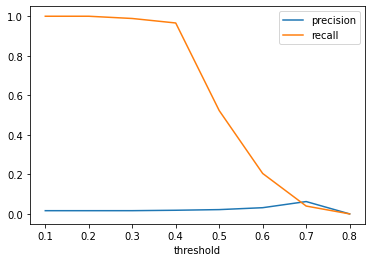

In [186]:
import matplotlib.pyplot as plt

pandas_df.plot.line(x='threshold', y=['precision','recall'])

plt.show()

In [187]:
pandas_df

,threshold,precision,recall,f1,TP,TN,FP,FN
0,0.1,0.016317,1.000000,0.032111,176,0,10610,0
1,0.2,0.016334,1.000000,0.032143,176,11,10599,0
2,0.3,0.016420,0.988636,0.032303,174,187,10423,2
3,0.4,0.018521,0.965909,0.036344,170,1601,9009,6
4,0.5,0.021775,0.522727,0.041809,92,6477,4133,84
5,0.6,0.031469,0.204545,0.054545,36,9502,1108,140
6,0.7,0.062500,0.039773,0.048611,7,10505,105,169
7,0.8,0.000000,0.000000,0.000000,0,10605,5,176


This model is better than the previous one. In previous model everything was predicted to 0. Where as after addigng the weights, it is giving somehwat better results. 
With threshold 0.4, it is giving better results and 0.5 it fall down to half, which means the correct spot is somether between these two.

In [188]:
#Let us see the recall and precission for 0.4, 0.425, 0.45
result_list = [] 
threshold_list = [0.4,0.425,0.45,0.475]
for i in threshold_list:
    test_pred = test_result.withColumn('label_p',when(element_extrac(test_result["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("delinquent==1 AND label_p==1").count()
    FP = test_pred.filter("delinquent==0 AND label_p==1").count()
    FN = test_pred.filter("delinquent==1 AND label_p==0").count()
    TN = test_pred.filter("delinquent==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    f1 = 0.0
    if recall+presession != 0:
        f1 = 2*((presession*recall)/(recall+presession))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(f1)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [189]:
schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('f1', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])
rdd = spark.sparkContext.parallelize(result_list)

thresh_df = spark.createDataFrame(rdd,schema)

pandas_df = thresh_df.toPandas()

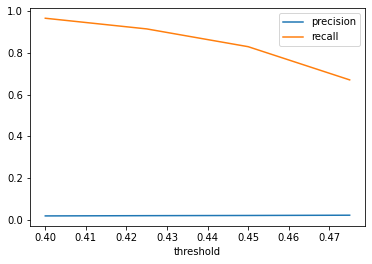

In [190]:
import matplotlib.pyplot as plt

pandas_df.plot.line(x='threshold', y=['precision','recall'])

plt.show()

In [191]:
pandas_df

,threshold,precision,recall,f1,TP,TN,FP,FN
0,0.400,0.018521,0.965909,0.036344,170,1601,9009,6
1,0.425,0.019738,0.914773,0.038642,161,2614,7996,15
2,0.450,0.020636,0.829545,0.040270,146,3681,6929,30
3,0.475,0.021909,0.670455,0.042431,118,5342,5268,58


I would choose 0.425 as a threshold, In that case, I can stop a majority of defaulters from entering into the system and if there is any loss from defaulters, that would be covered by other means.

### Now, let us try over sampling the data and train and test the model

In [192]:
cols_for_model = ['CODE_GENDER','YEARS_OF_EXPERIENCE','FLAG_OWN_REALTY','WOE_NAME_EDUCATION_TYPE','WOE_NAME_FAMILY_STATUS',
                 'WOE_NAME_FAMILY_STATUS','WOE_NAME_HOUSING_TYPE','WOE_NAME_HOUSING_TYPE','WOE_OCCUPATION_TYPE',
                 'delinquent']
application_record_for_model_building = application_record.select(*cols_for_model)

In [193]:
cols_for_model.remove('delinquent')
independent_cols = cols_for_model 

In [194]:
major_df = application_record_for_model_building.filter(col("delinquent") == 0)
minor_df = application_record_for_model_building.filter(col("delinquent") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

[Stage 4372:============================>                           (2 + 0) / 4]

ratio: 58


In [195]:
from pyspark.sql.functions import explode,array
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

21/07/13 13:55:57 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+-----------+-------------------+---------------+-----------------------+----------------------+----------------------+---------------------+---------------------+-------------------+----------+
|CODE_GENDER|YEARS_OF_EXPERIENCE|FLAG_OWN_REALTY|WOE_NAME_EDUCATION_TYPE|WOE_NAME_FAMILY_STATUS|WOE_NAME_FAMILY_STATUS|WOE_NAME_HOUSING_TYPE|WOE_NAME_HOUSING_TYPE|WOE_OCCUPATION_TYPE|delinquent|
+-----------+-------------------+---------------+-----------------------+----------------------+----------------------+---------------------+---------------------+-------------------+----------+
|          1|                  4|              0|    -0.3324458676896392|   0.13868159394241372|   0.13868159394241372| 0.018571206026937258| 0.018571206026937258| 0.0808839047699536|         0|
|          1|                  4|              0|    -0.3324458676896392|   0.13868159394241372|   0.13868159394241372| 0.018571206026937258| 0.018571206026937258| 0.0808839047699536|         0|
|          1|            

In [196]:
assembler = VectorAssembler(inputCols=independent_cols, outputCol='ss_features')
combined_df = assembler.transform(combined_df)
standard_scalar = StandardScaler(inputCol='ss_features',outputCol='features')
combined_df = standard_scalar.fit(combined_df).transform(combined_df)

In [197]:
train, test = combined_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 50295


[Stage 4490:===============================================>    (365 + 4) / 400]

Test Dataset Count: 21274


In [198]:
train.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|25072|
|         0|25223|
+----------+-----+



In [199]:
test.groupBy(target_col).count().show()

+----------+-----+
|delinquent|count|
+----------+-----+
|         1|10656|
|         0|10618|
+----------+-----+



In [200]:
lr = LogisticRegression(featuresCol='features', labelCol=target_col)
model = lr.fit(train)

In [201]:
train_result = model.evaluate(train)

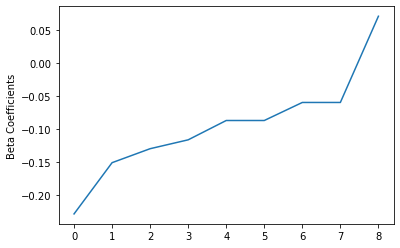

In [202]:
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

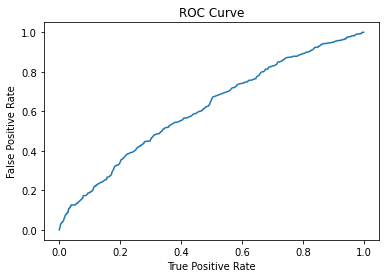

Training set areaUnderROC: 0.614242587422046


In [203]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [204]:
y_true = train_result.predictions.select(['delinquent']).collect()
y_pred = train_result.predictions.select(['prediction']).collect()

In [205]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59     25223
           1       0.58      0.54      0.56     25072

    accuracy                           0.58     50295
   macro avg       0.58      0.58      0.58     50295
weighted avg       0.58      0.58      0.58     50295



In [206]:
test_result = model.transform(test)

In [207]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59     25223
           1       0.58      0.54      0.56     25072

    accuracy                           0.58     50295
   macro avg       0.58      0.58      0.58     50295
weighted avg       0.58      0.58      0.58     50295



In [208]:
TP = test_result.filter("delinquent==1 AND prediction==1.0").count()
FP = test_result.filter("delinquent==0 AND prediction==1.0").count()
FN = test_result.filter("delinquent==1 AND prediction==0.0").count()
TN = test_result.filter("delinquent==0 AND prediction==0.0").count()

In [209]:
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN: ", TN)

TP:  5836
FP:  4178
FN:  4820
TN:  6440


In [210]:
#Let us see the recall and precission for 0.3,0.4,0.425,0.45,0.475,0.5,0.6
result_list = [] 
threshold_list = [0.3,0.4,0.425,0.45,0.475,0.5,0.6]
for i in threshold_list:
    test_pred = test_result.withColumn('label_p',when(element_extrac(test_result["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("delinquent==1 AND label_p==1").count()
    FP = test_pred.filter("delinquent==0 AND label_p==1").count()
    FN = test_pred.filter("delinquent==1 AND label_p==0").count()
    TN = test_pred.filter("delinquent==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    f1 = 0.0
    if recall+presession != 0:
        f1 = 2*((presession*recall)/(recall+presession))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(f1)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [211]:
schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('f1', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])
rdd = spark.sparkContext.parallelize(result_list)

thresh_df = spark.createDataFrame(rdd,schema)

pandas_df = thresh_df.toPandas()

In [212]:
pandas_df

,threshold,precision,recall,f1,TP,TN,FP,FN
0,0.300,0.505140,0.982264,0.667177,10467,364,10254,189
1,0.400,0.526677,0.901370,0.664867,9605,1986,8632,1051
2,0.425,0.540784,0.857357,0.663230,9136,2860,7758,1520
3,0.450,0.545576,0.766704,0.637509,8170,3813,6805,2486
4,0.475,0.565181,0.629411,0.595569,6707,5458,5160,3949
5,0.500,0.582784,0.547673,0.564683,5836,6440,4178,4820
6,0.600,0.632484,0.193318,0.296126,2060,9421,1197,8596


I would select 0.45 as I have a preety good recall and at a same time there are some false positives as well who might get into the system. But, out all I can make a profit balancing both.

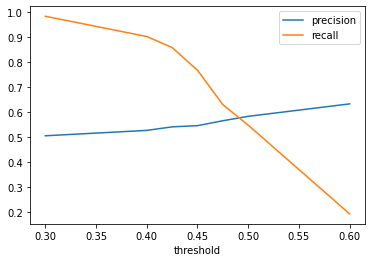

In [213]:
import matplotlib.pyplot as plt

pandas_df.plot.line(x='threshold', y=['precision','recall'])

plt.show()

In [214]:
ks_df = test_result.select(col('probability'),col('delinquent'))
element_extrac=udf(lambda v:float(v[1]),FloatType())
ks_df = ks_df.withColumn('probability',element_extrac(ks_df["probability"]))

ks_df = ks_df.orderBy(col('probability').desc())

discretizer = QuantileDiscretizer(numBuckets=10, inputCol="probability", outputCol="bucket")
ks_df = discretizer.fit(ks_df).transform(ks_df)

min_probability = ks_df.groupBy('bucket').min('probability').alias('min_probability')
max_probability = ks_df.groupBy('bucket').max('probability').alias('max_probability')
bad = ks_df.filter(col('delinquent') == 1).groupBy('bucket').count().alias('bad')
good = ks_df.filter(col('delinquent') == 0).groupBy('bucket').count().alias('good')
total = ks_df.groupBy('bucket').count().alias('total')
total_bad = ks_df.filter(col('delinquent') == 1).count()
totoa_good = ks_df.filter(col('delinquent') == 0).count()

min_probability = min_probability.withColumnRenamed('min(probability)','min_probability')
max_probability = max_probability.withColumnRenamed('max(probability)','max_probability')
bad = bad.withColumnRenamed('count','bad')
good = good.withColumnRenamed('count','good')
total = total.withColumnRenamed('count','total')

ks_df = ks_df.drop('probability')
ks_df = ks_df.drop('delinquent')
ks_df = ks_df.dropDuplicates()

min_probability = min_probability.dropDuplicates()
max_probability = max_probability.dropDuplicates()
bad = bad.dropDuplicates()
good = good.dropDuplicates()
total = total.dropDuplicates()
ks_df = ks_df.dropDuplicates()

ks_df = ks_df.join(min_probability, on='bucket', how='left')

ks_df = ks_df.join(max_probability, on='bucket', how='left')
ks_df = ks_df.join(bad, on='bucket', how='left')
ks_df = ks_df.join(good, on='bucket', how='left')
ks_df = ks_df.join(total, on='bucket', how='left')

buckets = list((ks_df.select('bucket').toPandas())['bucket'])

ks_df = ks_df.withColumn('cum_bad',ks_df.bad)
ks_df = ks_df.withColumn('cum_good',ks_df.good)
for bucket in buckets:
    ks_df = ks_df.withColumn('cum_bad',when(col('bucket') == bucket,ks_df.filter(col('bucket') >= bucket).select(col('bad')).groupBy().sum().collect()[0][0]).otherwise(ks_df.cum_bad))
    ks_df = ks_df.withColumn('cum_good',when(col('bucket') == bucket,ks_df.filter(col('bucket') >= bucket).select(col('good')).groupBy().sum().collect()[0][0]).otherwise(ks_df.cum_good))

ks_df = ks_df.withColumn('cum_bad_per',(ks_df.cum_bad/total_bad)*100)
ks_df = ks_df.withColumn('cum_good_per',(ks_df.cum_good/totoa_good)*100)
ks_df = ks_df.withColumn('ks',ks_df.cum_bad_per-ks_df.cum_good_per)

In [215]:
ks_df.orderBy(col('bucket').desc()).toPandas()

,bucket,min_probability,max_probability,bad,good,total,cum_bad,cum_good,cum_bad_per,cum_good_per,ks
0,9.0,0.623501,0.844856,1636,821,2457,1636,821,15.352853,7.732153,7.620700
1,8.0,0.573049,0.623202,968,815,1783,2604,1636,24.436937,15.407798,9.029139
2,7.0,0.545288,0.572998,1456,762,2218,4060,2398,38.100601,22.584291,15.516310
3,6.0,0.520544,0.545209,1099,975,2074,5159,3373,48.414039,31.766811,16.647228
4,5.0,0.487593,0.520397,1010,1246,2256,6169,4619,57.892267,43.501601,14.390666
5,4.0,0.467400,0.487511,1367,1322,2689,7536,5941,70.720721,55.952157,14.768564
6,3.0,0.450407,0.467372,605,786,1391,8141,6727,76.398273,63.354681,13.043593
7,2.0,0.423746,0.450299,1070,1108,2178,9211,7835,86.439565,73.789791,12.649774
8,1.0,0.383666,0.423736,768,1297,2065,9979,9132,93.646772,86.004897,7.641874
9,0.0,0.139716,0.383513,677,1486,2163,10656,10618,100.000000,100.000000,0.000000


We can see that at 0.6, we have the max difference and the KS value is 16.46.

Based on the statiscs, I would prefer Model 3 or last model as it is giving good results.